In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
#from scipy.stats import gmean

import cvxpy as cp

import empyrical as emp
import time
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
%matplotlib inline

In [3]:
def cvx_opt(df):
    # convert sharpe maximization to standard quadratic program according to:
    # http://people.stat.sc.edu/sshen/events/backtesting/reference/maximizing%20the%20sharpe%20ratio.pdf
    
    # solve QP using cvxpy
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    # define adjusted constraint matrix
    # min weight of each asset = .1
    A = np.asmatrix([[1,0,0],[0,1,0],[0,0,1]])
    bounds = np.asmatrix([0.1,.1,0.1])
    A_mod = A - bounds.T

    y = cp.Variable(len(cov))
    funct = cp.quad_form(y, cov)
    prob = cp.Problem(cp.Minimize(funct), 
                   [y@u == 1, 
                    y >= 0,
                    A_mod@y.T >= 0 # additional linear constraints
                   ])
    r = prob.solve()
    
    if np.isinf(r):
        x = np.full((len(cov),),1/len(cov)) # equal weight, inf occurs if all mean returns are negative
    else:
        x = y.value/y.value.sum()

    return x

In [4]:
def cvx_opt_minv(df):
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    #set up bounds
    A = np.identity(len(cov))
    bounds = np.array([0.1,0.1,0.1])
    
    
    w = cp.Variable(len(cov)) 
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Minimize(risk), # different objective function
                   [cp.sum(w) == 1, 
                    w >= 0,
                   A@w.T >= bounds])

    
    
    r = prob.solve()
    
    if np.isinf(r):
        x = np.full((len(cov),),1/len(cov)) # equal weight, inf occurs if all mean returns are negative
    else:
        x = w.value

    return x

In [5]:
df_feat_train = pd.read_csv("../data/processed_features_train.csv",index_col=0,parse_dates=True)
returns_train = pd.read_csv("../data/processed_returns_train.csv",index_col=0,parse_dates=True)

df_feat_test = pd.read_csv("../data/processed_features_test.csv",index_col=0,parse_dates=True)
returns_test = pd.read_csv("../data/processed_returns_test.csv",index_col=0,parse_dates=True)

In [6]:
print(df_feat_train.shape)
print(returns_train.shape)

print(df_feat_test.shape)
print(returns_test.shape)


(299, 36)
(6222, 3)
(168, 36)
(3497, 3)


In [7]:
# stock and commodity returns are negatively correlated to vol
# add filtering to algorithm
returns_train.resample('M').std().join(returns_train.resample('M').mean(),rsuffix='_mean',lsuffix='_std').corr()

,Stock_Returns_std,Bond_Returns_std,Commodity_Returns_std,Stock_Returns_mean,Bond_Returns_mean,Commodity_Returns_mean
Stock_Returns_std,1.000000,0.359024,0.233216,-0.272005,0.088358,-0.067148
Bond_Returns_std,0.359024,1.000000,-0.002791,-0.066617,0.074251,-0.098306
Commodity_Returns_std,0.233216,-0.002791,1.000000,-0.040414,-0.047669,-0.089793
Stock_Returns_mean,-0.272005,-0.066617,-0.040414,1.000000,0.161326,-0.021450
Bond_Returns_mean,0.088358,0.074251,-0.047669,0.161326,1.000000,-0.042045
Commodity_Returns_mean,-0.067148,-0.098306,-0.089793,-0.021450,-0.042045,1.000000


In [8]:
max_r = returns_train['Stock_Returns'].rolling(21).std().quantile(.95)
max_b = returns_train['Bond_Returns'].rolling(21).std().quantile(.95)
max_c = returns_train['Commodity_Returns'].rolling(21).std().quantile(.95)

In [9]:
class port_opt:
    
    def __init__(self,model):
        self.model = model
        self.wts = []
        self.wt0 = np.array([[.6,.3,.1]]).reshape(3,1)
        self.wts_opt = None
        self.OptimizeFunct_1 = None
        self.OptimizeFunct_2 = None
        self.d = []
        self.dst =[]
        self.nearest = None
        self.rets = None
        self.stds = None
        self.measures = None
        self.all_rets = None
        self.dailyM = None
        
        
        
    def predict_port(self,df_feat_train,df_feat_test,returns_train,returns_test,verbose=False):
        
        for i in range(len(df_feat_test)-1):
            self.dst, nearest = self.model.kneighbors([df_feat_test.values[i]],return_distance=True)

            # we should get weights from similar period + 1 to match what we are trying to predict 
            mask = returns_train.index.strftime('%m-%Y').isin(df_feat_train.iloc[np.fmin(nearest+1,np.full((self.model.n_neighbors),[len(df_feat_train)-1]))[0],:].index.strftime('%m-%Y'))
            f = returns_train[mask]

            # check if greater than max std
            if np.any(returns_test.loc[df_feat_test.index[i].strftime('%m-%Y')].std() > [max_r,99,max_c]):
                if verbose:
                    print('min var: {}'.format(i))
                wt = self.OptimizeFunct_2(f)
            else:
                wt = self.OptimizeFunct_1(f)
            self.d.append(self.dst[0])
            self.wts.append(wt)
        self.d = np.array(self.d)
        self.wts = np.array(self.wts)
        return None
        
    def calc_results(self):
        self.rets=[]
        self.stds=[]
        self.measures=[]
        self.all_rets=np.empty((0,3))
        self.dailyM=None

        for i in range(len(self.wts)):
            wts = np.asarray(self.wts[i]).reshape(3,1)
            next_month = df_feat_test.index[i] + relativedelta(months=1)
            next_month = datetime.datetime.strftime(next_month,'%m-%Y')

            ret = np.asarray(returns_test.loc[next_month].mean()).dot(wts)
            std = np.sqrt(wts.T.dot(returns_test.loc[next_month].cov().values).dot(wts))
            shrp = ret/std

            ret2 = returns_test.loc[next_month].mean().dot(self.wt0)
            std2 = np.sqrt(self.wt0.T.dot(returns_test.loc[next_month].cov().values).dot(self.wt0))
            shrp2 = ret2/std2

            ret3 = returns_test.loc[next_month].mean().dot(self.wts_opt)
            std3 = np.sqrt(self.wts_opt.T.dot(returns_test.loc[next_month].cov().values).dot(self.wts_opt))
            shrp3 = ret3/std3

            self.rets.append((ret[0],ret2[0],ret3))
            self.stds.append((std[0,0],std2[0,0],std3))
            self.measures.append((shrp[0,0],shrp2[0,0],shrp3))
            self.all_rets = np.concatenate((self.all_rets,np.column_stack([returns_test.loc[next_month].values.dot(wts),returns_test.loc[next_month].values.dot(self.wt0),returns_test.loc[next_month].values.dot(self.wts_opt)])))


        self.rets = np.array(self.rets)
        self.stds = np.array(self.stds)
        self.measures = np.array(self.measures)
        
        self.dailyM = np.mean(self.all_rets,axis=0)/np.std(self.all_rets,axis=0)
        
        return None
    
    def summary(self):
        
        strategy_list = ['','Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static']

        print(tabulate(
                [strategy_list,
                 ['CAGR',*list(emp.cagr(self.all_rets))],
                 ['Returns',*list(np.mean(self.all_rets,axis=0)*252)],
                 ['Std',*list(np.std(self.all_rets,axis=0)*np.sqrt(252))],
                 ['Sharpe',*list(self.dailyM*np.sqrt(252))],
                 ['Max Drawdown',*list(emp.max_drawdown(self.all_rets))],
                 ['Sortino',*list(emp.sortino_ratio(self.all_rets))],
                 ['Calmar',emp.calmar_ratio(self.all_rets[:,0]),emp.calmar_ratio(self.all_rets[:,1]),emp.calmar_ratio(self.all_rets[:,2])]
                ],
                headers="firstrow",tablefmt="github"))
        return None
    
    def plots(self):
        
        
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,28))
        

        l = len((np.insert((self.all_rets+1).cumprod(axis=0),0,1,axis=0)))
        ax1.plot(pd.DataFrame(index=returns_test.iloc[-l:].index,data=(np.insert((self.all_rets+1).cumprod(axis=0),0,1,axis=0))))
        ax1.set_title('Growth of a dollar')
        ax1.legend(loc='best',labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])

        l = len(emp.roll_max_drawdown(self.all_rets[:,0], window=252*1))

        datadf = pd.DataFrame({0:emp.roll_max_drawdown(self.all_rets[:,0], window=252*1),
                                1:emp.roll_max_drawdown(self.all_rets[:,1], window=252*1),
                                2:emp.roll_max_drawdown(self.all_rets[:,2], window=252*1)},
                             index = returns_test.iloc[-l:].index )

        ax2.plot(datadf)
        ax2.legend(loc='best',labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])
        ax2.set_title('Rolling 1y Max Drawdown')
        
        ax3.plot((pd.DataFrame(self.all_rets,index=returns_test.iloc[-len(self.all_rets):].index).rolling(252*3).apply(lambda x: x.mean()/x.std())*np.sqrt(252)).dropna())
        ax3.legend(labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])
        ax3.set_title('Rolling 3y Sharpe')
        
        r0 = pd.DataFrame(self.wts,index=df_feat_test.iloc[-len(self.wts):].index)
        ax4.stackplot(r0.index,r0.T)
        ax4.legend(loc='center right',labels=['Stock','Bond','Commodity'],bbox_to_anchor=(0,0))
        ax4.set_title('Dynamic Weights')
        
        return None

# Training
- Check 3 different splits of training set to find best value of n

In [10]:
st = time.time()

X_train, X_val = df_feat_train.loc[:'1991'], df_feat_train.loc['1992':]
r2_train, r2_val = returns_train.loc[:'1991'], returns_train.loc['1992':]

out1 = []

for i in range(5, 61):

    tst1 = port_opt(NearestNeighbors())
    tst1.model.n_neighbors=i
    tst1.OptimizeFunct_1 = cvx_opt
    tst1.OptimizeFunct_2 = cvx_opt_minv
    tst1.wts_opt = tst1.OptimizeFunct_1(r2_train)
    tst1.model.fit(X_train.values)
    tst1.predict_port(X_train,X_val,r2_train,r2_val)
    tst1.calc_results()
    out1.append(tst1.dailyM*np.sqrt(252))

out1 = np.array(out1)


X_train, X_val = df_feat_train.loc[:'1993'], df_feat_train.loc['1994':]
r2_train, r2_val = returns_train.loc[:'1993'], returns_train.loc['1994':]

out2 = []

for i in range(5, 61):

    tst2 = port_opt(NearestNeighbors())
    tst2.model.n_neighbors=i
    tst2.OptimizeFunct_1 = cvx_opt
    tst2.OptimizeFunct_2 = cvx_opt_minv
    tst2.wts_opt = tst2.OptimizeFunct_1(r2_train)
    tst2.model.fit(X_train.values)
    tst2.predict_port(X_train,X_val,r2_train,r2_val)
    tst2.calc_results()
    out2.append(tst2.dailyM*np.sqrt(252))

out2 = np.array(out2)

X_train, X_val = df_feat_train.loc[:'1995'], df_feat_train.loc['1996':]
r2_train, r2_val = returns_train.loc[:'1995'], returns_train.loc['1996':]

out3 = []

for i in range(5, 61):

    tst3 = port_opt(NearestNeighbors())
    tst3.model.n_neighbors=i
    tst3.OptimizeFunct_1 = cvx_opt
    tst3.OptimizeFunct_2 = cvx_opt_minv
    tst3.wts_opt = tst3.OptimizeFunct_1(r2_train)
    tst3.model.fit(X_train.values)
    tst3.predict_port(X_train,X_val,r2_train,r2_val)
    tst3.calc_results()
    out3.append(tst3.dailyM*np.sqrt(252))

out3 = np.array(out3)

X_train, X_val = df_feat_train.loc[:'1997'], df_feat_train.loc['1998':]
r2_train, r2_val = returns_train.loc[:'1997'], returns_train.loc['1998':]

out4 = []

for i in range(5, 61):

    tst4 = port_opt(NearestNeighbors())
    tst4.model.n_neighbors=i
    tst4.OptimizeFunct_1 = cvx_opt
    tst4.OptimizeFunct_2 = cvx_opt_minv
    tst4.wts_opt = tst4.OptimizeFunct_1(r2_train)
    tst4.model.fit(X_train.values)
    tst4.predict_port(X_train,X_val,r2_train,r2_val)
    tst4.calc_results()
    out4.append(tst4.dailyM*np.sqrt(252))

out4 = np.array(out4)

endt = time.time()

print('runtime: {:.3f} mins'.format((endt-st)/60))

runtime: 39.417 mins


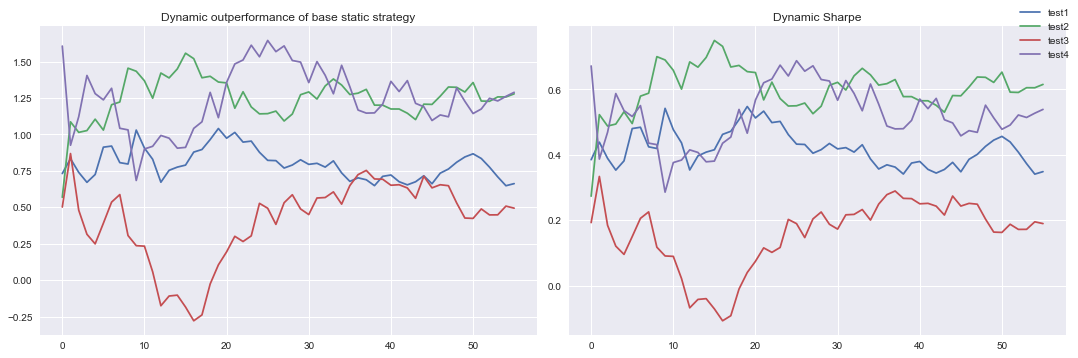

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(out1[:,0]/out1[:,1])
ax1.plot(out2[:,0]/out2[:,1])
ax1.plot(out3[:,0]/out3[:,1])
ax1.plot(out4[:,0]/out4[:,1])
ax1.set_title('Dynamic outperformance of base static strategy')

ax2.plot(out1[:,0])
ax2.plot(out2[:,0])
ax2.plot(out3[:,0])
ax2.plot(out4[:,0])
ax2.set_title('Dynamic Sharpe')

fig.legend(['test1','test2','test3','test4'])

fig.tight_layout()


In [12]:
#choosing 36 months (3y), matches our 3y rolling z score feature

In [13]:
out_final = []

i=36

final = port_opt(NearestNeighbors())
final.model.n_neighbors=i
final.OptimizeFunct_1 = cvx_opt
final.OptimizeFunct_2 = cvx_opt_minv
final.wts_opt = final.OptimizeFunct_1(returns_train)
final.model.fit(df_feat_train.values)
final.predict_port(df_feat_train,df_feat_test,returns_train,returns_test)
final.calc_results()
out_final.append(final.dailyM*np.sqrt(252))

out_final = np.array(out_final)

In [14]:
final.summary()
print('\n Sharpe outperformance over base : {:.3f}x'.format((out_final[:,0]/out_final[:,1])[0]))


|              |   Dynamic Algo |   Base: [0.6 0.3 0.1] |   Training_Opt_Static |
|--------------|----------------|-----------------------|-----------------------|
| CAGR         |      0.0536106 |             0.0557123 |             0.0359974 |
| Returns      |      0.0543081 |             0.0609254 |             0.0370886 |
| Std          |      0.0645048 |             0.115692  |             0.058687  |
| Sharpe       |      0.841923  |             0.526617  |             0.631973  |
| Max Drawdown |     -0.133972  |            -0.385972  |            -0.168178  |
| Sortino      |      1.22893   |             0.733899  |             0.913838  |
| Calmar       |      0.400163  |             0.144343  |             0.214043  |

 Sharpe outperformance over base : 1.599x


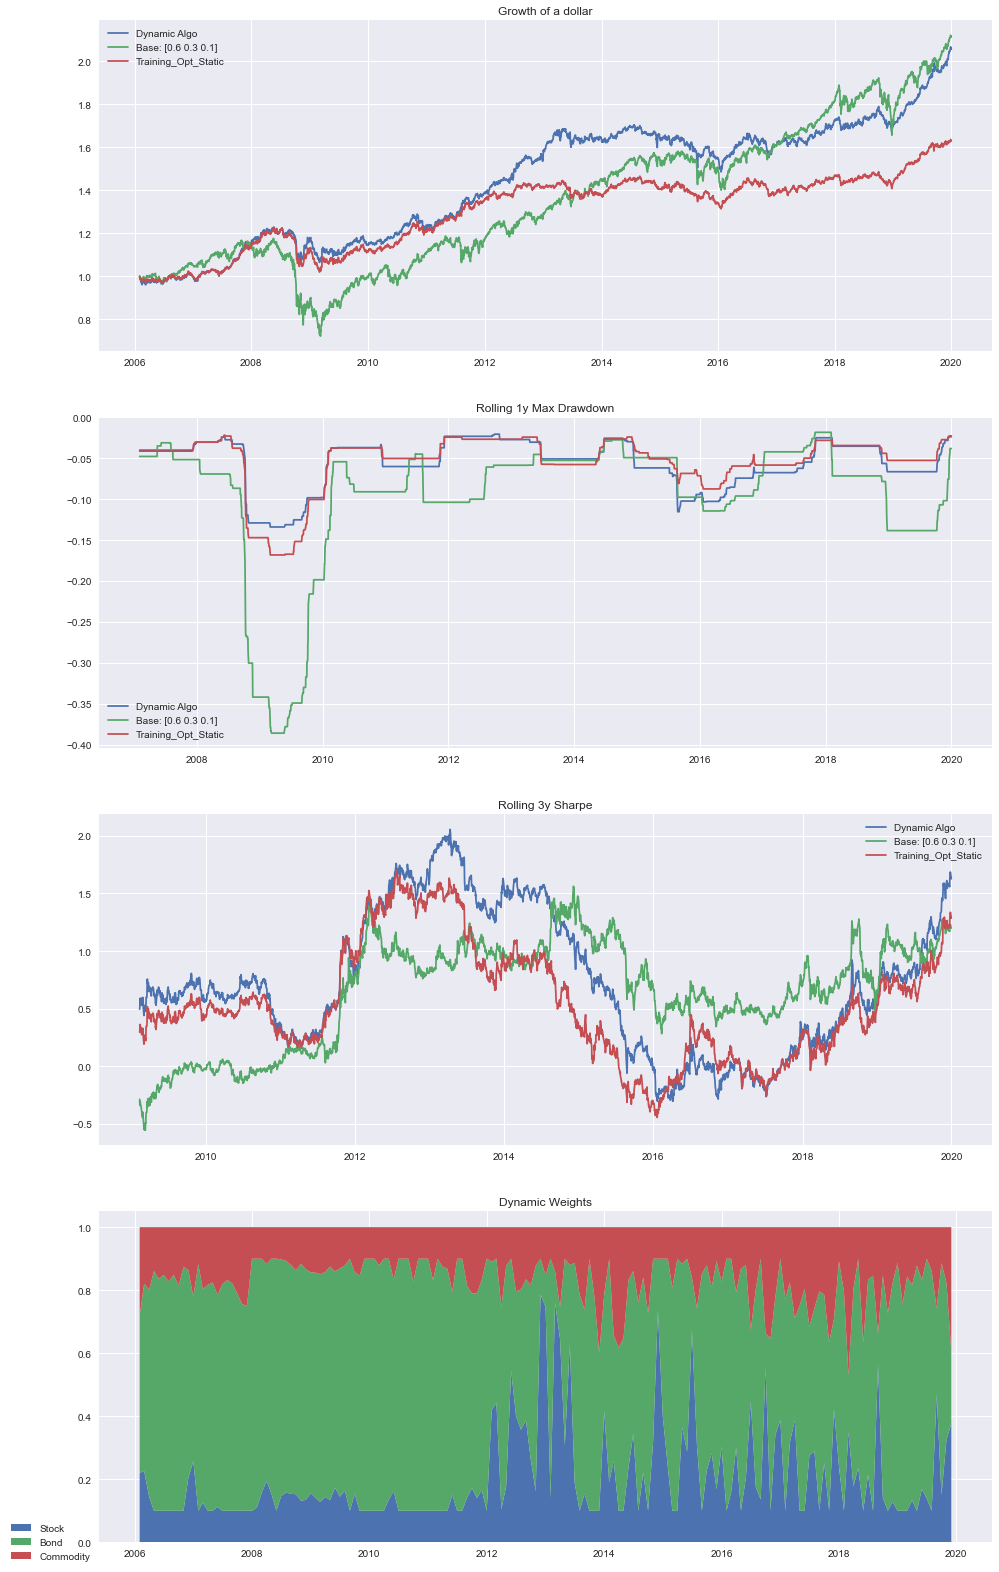

In [15]:
final.plots()

In [16]:
# results even beat best possible static portfolio from test set if returns were known ahead of time!
post_wts = cvx_opt(returns_test)
best = returns_test.mean().dot(post_wts)*np.sqrt(252) / (np.sqrt(post_wts.T.dot(returns_test.cov().values).dot(post_wts)))
print('Best possible static sharpe: {:.3f}'.format(best))
print('Dynamic sharpe: {:.3f}'.format(out_final[0,0]))

Best possible static sharpe: 0.819
Dynamic sharpe: 0.842


# Base Algorithm
> **At the end of each month i, we will use observed economic data from that month to determine the constrained asset allocation strategy for next month i+1**

i month; n number nearest neighbors;
1. For each new i in test set, calculate nearest n months in training set based on economic feature distance
2. Calculate std of each asset daily returns in month i  
    2a. If any std(i) > std_max (95% percentile of asset return in training set): weights = min_variance(n+1)  
      *[min variance weights for historical next month returns from each n]*  
    2b. std(i) <= std_max: weights = max_sharpe(n+1)  
    *[max sharpe weights for historical next month returns from each n]*

# Ideas for Improvement
1. Expanding training window
2. Improve features and scaling
3. Expand problem to clustering model, max sharpe within clusters, min std otherwise
4. Research different distance metrics
5. Create additional model to predict theoretical max sharpe, add as feature